In [53]:
%reset -f
import os
import sys
import pathlib
# import argparse

sys.path.append('/home/psimmerl/mds_analysis')

import math
import numpy as np
import numba as nb
from math import ceil, floor

import pickle

# from src.helper_functions import alert, Table
# from src.histo_utilities import std_color_list as SCL

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
# from ROOT import TNtuple, TTree, TBranch, RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors

from src.helper_functions import alert, Table, weight_calc

# **************************** #
OUT_DIR = 'reports/weekly/2024-03-27'
LOCAL_OUT_DIR = '/home/psimmerl/mds_analysis'  # os.getcwd()

DATA_VERSION = '6'
LUMI = 23.02 * 1000
PI = rt.TMath.Pi()

LOCAL_DATA_DIR = '/home/psimmerl/mds_analysis/data'  # os.getcwd() + '/data/raw'
DATA_DIR = LOCAL_DATA_DIR#'TIER2' if 'caltech' in os.uname()[1] else 'LOCAL'
OUT_DIR = f'{LOCAL_OUT_DIR}/{OUT_DIR}'

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

ROOT_ERROR_LEVEL = 1001  # rt.kInfo + 1
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL

SCL = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]

gc = []

# **************** #

TAG_CATEGORY = ('csccsc', 'cscdt')[0]
SIZE_VAR = TAG_CATEGORY[3:]

if 'csccsc' in TAG_CATEGORY:
    LOW_MET, HIGH_MET = 75, 150
if 'cscdt' in TAG_CATEGORY:
    LOW_MET, HIGH_MET = 75, 150

FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_scs_low_rdf.root'
FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_scs_low_rdf.root'

# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_l1_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_l1_rdf.root'

# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_l1_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_l1_rdf.root'


# **************** #
print(f'{TAG_CATEGORY=}')
print(f'{SIZE_VAR=}')
print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
print('')

rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3),
}

print('Events Read:')
for key, rdf in rdfs.items():
    # print('!!!!!!!!!!!!!!!!!!!!')
    # print('!! CUTTING ON MET !!')
    # print('!!!!!!!!!!!!!!!!!!!!')
    # rdf = rdf.Filter('met > 150')

    if SIZE_VAR == 'csc':
        rdf = rdf.Alias('tag_size', 'csc1Size')
        rdf = rdf.Alias('tag_ctau', 'csc1CTau')
        rdf = rdf.Define('tag_dT', 'abs(csc0TimeWeighted - csc1TimeWeighted)')
        # rdf = rdf.Define('tag_dT', 'csc0TimeWeighted - csc1TimeWeighted')
        # rdf = rdf.Filter('tag_dT < 5')
    elif SIZE_VAR == 'dt':
        rdf = rdf.Alias('tag_size', 'dtSize')
        rdf = rdf.Alias('tag_ctau', 'dtCTau')
        rdf = rdf.Define('tag_dT', 'abs(cscTimeWeighted - dt_match_RPCBx_dPhi0p5)')

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf

TAG_CATEGORY='csccsc'
SIZE_VAR='csc'

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_csccsc_scs_low_rdf.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_csccsc_scs_low_rdf.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-03-27'

Events Read:
  mc = 2,388 (1,442.57)
  r3 = 5,317 (5,317.00)


Signal 1430.4849209496751 events
Data 1578.0 events


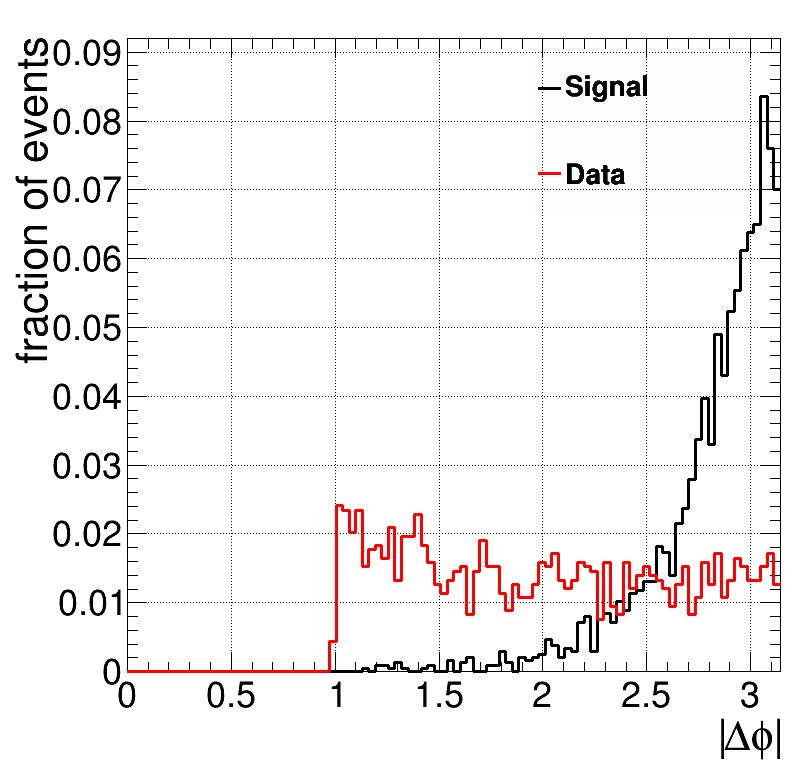

In [167]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.67, 0.72, 0.94, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

wt = 'weight'

xv = 'tag_dPhi'
txy_label = f';|#Delta#phi|;events'
form =(txy_label,100,0,np.pi)

# **** #

dphi_cut = '1.0 < tag_dPhi'
bump_cut = '(0.55 < tag_dPhi) && (tag_dPhi < 0.8)'
bump_cut = '(0.55 < tag_dPhi) && (tag_dPhi < 0.8) && (tag_dEta < 0.4)'
# bump_cut = 'tag_dR < 1'

better_bcut = '-1 < tag_dPhi'
better_bcut = '1.0 < tag_dPhi'
better_bcut = ''
better_bcut = '(1.0 < tag_dPhi) && (csc1MaxStationRatio < 0.9)'
better_bcut = '!((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
better_bcut = f'(1.0 < tag_dPhi) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
better_bcut = f'(csc1MaxStationRatio < 0.9) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
better_bcut = f'(1.0 < tag_dPhi) && (csc1MaxStationRatio < 0.9) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# better_bcut = f'{dphi_cut} && (csc1MaxStationRatio < 0.9) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# better_bcut = f'{dphi_cut} && (csc1MaxStationRatio < 0.9) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# Signal 735.1774277009099 events
# Data 547.0 events
# better_bcut = f'{dphi_cut} && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# better_bcut = '!((csc1AvgStation10  == 4) && (csc1MaxStationRatio > 0.7))'

# better_bcut = 'tag_dEta > 0.5'
# better_bcut = 'tag_dR > 1.5'#0.9'

better_bcut = 'tag_dT < 4'
# better_bcut = '(tag_dPhi > 1.0) && (tag_dT < 4)'

better_bcut = '(csc0AvgStation10 < 2) || (csc1NStation10 > 1.5)'


# **** #

h1 = rdfs['mc'].Filter(dphi_cut).Histo1D(('Signal',*form),xv,wt).GetValue()
h2 = rdfs['r3'].Filter(dphi_cut).Histo1D(('Data',*form),xv,wt).GetValue()
hhs = [h1,h2]

# h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,wt).GetValue()
# h2 = rdfs['r3'].Filter(f'!({bump_cut})').Histo1D(('Data (no bump)',*form),xv,wt).GetValue()
# h3 = rdfs['r3'].Filter(bump_cut).Histo1D(('Data (bump)',*form),xv,wt).GetValue()
# hhs = [h1,h2,h3]

# h1 = rdfs['mc'].Filter(better_bcut).Histo1D(('Signal (Pass)',*form),xv,wt).GetValue()
# h2 = rdfs['r3'].Filter(better_bcut).Histo1D(('Data (Pass)',*form),xv,wt).GetValue()
# h3 = rdfs['r3'].Filter(f'!({better_bcut})').Histo1D(('Data (Fail)',*form),xv,wt).GetValue()
# hhs = [h1,h2, h3]


hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    print(hh.GetName(), nev, 'events')
    if hmax < 1 and nev:
        hh.Scale(1/hh.Integral())
        hh.GetYaxis().SetTitle('fraction of events')
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')

# l = TLine(1.0,0,1.0,hmax*1.1)
# l.SetLineColor(rt.kMagenta)
# l.SetLineWidth(3)
# l.Draw()

legend.Draw()

legend.Draw()
canvas.Draw()


In [55]:
# vars = {str(c):0 for c in rdfs['r3'].GetColumnNames()}
# for v in vars:
#     if v in ('weight','csc0CTau','csc1CTau','dtCTau', 'tag_ctau'):
#         continue
#     rd, rb = rdfs['r3'].Filter(dphi_cut), rdfs['r3'].Filter(bump_cut)
#     dmin, dmax, bmin, bmax = rd.Min(v), rd.Max(v), rb.Min(v), rb.Max(v)
#     dmin, dmax, bmin, bmax = dmin.GetValue(), dmax.GetValue(), bmin.GetValue(), bmax.GetValue()
    
#     # xmin, xmax = min([vs_bump.min(), vs_data.min()]), max([vs_bump.max(), vs_data.max()])
#     # xmin, xmax = max([dmin, bmin]), min([dmax, bmax])
#     xmin, xmax = min([dmin, bmin]), max([dmax, bmax])
#     rd = rdfs['mc']#.Filter(f'({dphi_cut}) && ({xmin} <= {v}) && ({v} <= {xmax})')
#     # rd = rdfs['r3'].Filter(f'({dphi_cut}) && ({xmin} <= {v}) && ({v} <= {xmax})')
#     rb = rdfs['r3'].Filter(f'({bump_cut}) && ({xmin} <= {v}) && ({v} <= {xmax})')
#     vs_data = rd.AsNumpy([v])[v].astype(float)
#     vs_bump = rb.AsNumpy([v])[v].astype(float)
#     ndata, nbump = len(vs_data), len(vs_bump)

#     nb_data = int((xmax-xmin)/(2.718*vs_data.std()*ndata**(-1/3))) if vs_data.std()>0 else 5
#     nb_bump = int((xmax-xmin)/(2.718*vs_bump.std()*nbump**(-1/3))) if vs_bump.std()>0 else 5
#     nb = min(nb_data, nb_bump)
#     # print(v, nb, xmin, xmax)

#     hdata = np.histogram(vs_data, nb, (xmin, xmax), density=True)
#     hbump = np.histogram(vs_bump, nb, (xmin, xmax), density=True)

#     rms = np.sum((hdata[0]-hbump[0])**2)**0.5
#     vars[v] = rms
#     print(v, rms)



csc0AvgStation10 0.2647120909583031
csc0Eta 0.31290869662188886
csc0JetVetoE 0.032910707818530636
csc0JetVetoLooseId 0.2524655767923215
csc0JetVetoPt 0.09150857146493106
csc0JetVetoTightId 0.4040730608658186
csc0MaxChamber 1.3999553489005965e-10
csc0MaxChamberRatio 7.162308943230163e-08
csc0MaxStation 0.3087669918805926
csc0MaxStationRatio 11.970133499858848
csc0Met_dPhi 0.13160518752105882
csc0MuonVetoE 0.000403483284145242
csc0MuonVetoGlobal 0.2541979688061721
csc0MuonVetoLooseId 0.6795528965282821
csc0MuonVetoPt 0.0009578954185093167
csc0NChamber 2.4246157736360123e-10
csc0NRechitChamberMinus11 0.0010940998519583522
csc0NRechitChamberMinus12 0.0010033471735236903
csc0NRechitChamberMinus13 0.001485652975333673
csc0NRechitChamberMinus21 8.293822234463742e-05
csc0NRechitChamberMinus22 0.0004188520094836368
csc0NRechitChamberMinus31 0.00019511768841111514
csc0NRechitChamberMinus32 0.0008043822729094615
csc0NRechitChamberMinus41 0.00043985882920455463
csc0NRechitChamberMinus42 0.00065153

In [56]:
print(r'\begin{center}')
print(r'\begin{tabular}{c|c}')
print(r'    \hline')
print(f'    Variable & Histo RMS \\\\')
print(r'    \hline')
for k, v in sorted([(k,v) for k, v in vars.items()], key=lambda x: -x[1])[:10]:
    print(f'    {k.replace("_"," ")} & {v:.2f} \\\\')
print(r'\end{tabular}')
print(r'\end{center}')

\begin{center}
\begin{tabular}{c|c}
    \hline
    Variable & Histo RMS \\
    \hline
    csc1MaxStationRatio & 13.59 \\
    csc0MaxStationRatio & 11.97 \\
    tag dR & 9.02 \\
    tag dPhi & 8.54 \\
    csc1NStation10 & 3.97 \\
    tag dEta & 3.14 \\
    csc0NStation10 & 1.59 \\
    csc1JetVetoTightId & 0.75 \\
    csc1JetVetoLooseId & 0.72 \\
    csc0MuonVetoLooseId & 0.68 \\
\end{tabular}
\end{center}


In [184]:
test_cols = [
    'csc0AvgStation10',
    # 'csc0CTau',
    'csc0Eta',
    'csc0JetVetoE',
    'csc0JetVetoLooseId',
    'csc0JetVetoPt',
    'csc0JetVetoTightId',
    'csc0MaxChamber',
    # 'csc0MaxChamberRatio', # Something is wrong with this variable
    'csc0MaxStation',
    'csc0MaxStationRatio',
    # 'csc0Met_dPhi',
    'csc0MuonVetoE',
    'csc0MuonVetoGlobal',
    'csc0MuonVetoLooseId',
    'csc0MuonVetoPt',
    'csc0NChamber',
    'csc0NRechitChamberMinus11',
    'csc0NRechitChamberMinus12',
    'csc0NRechitChamberMinus13',
    'csc0NRechitChamberMinus21',
    'csc0NRechitChamberMinus22',
    'csc0NRechitChamberMinus31',
    'csc0NRechitChamberMinus32',
    'csc0NRechitChamberMinus41',
    'csc0NRechitChamberMinus42',
    'csc0NRechitChamberPlus11',
    'csc0NRechitChamberPlus12',
    'csc0NRechitChamberPlus13',
    'csc0NRechitChamberPlus21',
    'csc0NRechitChamberPlus22',
    'csc0NRechitChamberPlus31',
    'csc0NRechitChamberPlus32',
    'csc0NRechitChamberPlus41',
    'csc0NRechitChamberPlus42',
    'csc0NStation10',
    'csc0Phi',
    'csc0R',
    'csc0Size',
    # 'csc0Time',
    # 'csc0TimeSpread',
    # 'csc0TimeSpreadWeightedAll',
    # 'csc0TimeWeighted',
    'csc0X',
    'csc0Y',
    'csc0Z',
    # 'csc0_match_MB1Seg_0p4',
    # 'csc0_match_RB1_0p4',
    # 'csc0_match_RE12_0p4',
    # 'csc0_match_dtSeg_0p4',
    #
    'csc1AvgStation10',
    # 'csc1CTau',
    'csc1Eta',
    'csc1JetVetoE',
    'csc1JetVetoLooseId',
    'csc1JetVetoPt',
    'csc1JetVetoTightId',
    'csc1MaxChamber',
    # 'csc1MaxChamberRatio', # Something is wrong with this variable
    'csc1MaxStation',
    'csc1MaxStationRatio',
    # 'csc1Met_dPhi',
    'csc1MuonVetoE',
    'csc1MuonVetoGlobal',
    'csc1MuonVetoLooseId',
    'csc1MuonVetoPt',
    'csc1NChamber',
    'csc1NRechitChamberMinus11',
    'csc1NRechitChamberMinus12',
    'csc1NRechitChamberMinus13',
    'csc1NRechitChamberMinus21',
    'csc1NRechitChamberMinus22',
    'csc1NRechitChamberMinus31',
    'csc1NRechitChamberMinus32',
    'csc1NRechitChamberMinus41',
    'csc1NRechitChamberMinus42',
    'csc1NRechitChamberPlus11',
    'csc1NRechitChamberPlus12',
    'csc1NRechitChamberPlus13',
    'csc1NRechitChamberPlus21',
    'csc1NRechitChamberPlus22',
    'csc1NRechitChamberPlus31',
    'csc1NRechitChamberPlus32',
    'csc1NRechitChamberPlus41',
    'csc1NRechitChamberPlus42',
    'csc1NStation10',
    'csc1Phi',
    'csc1R',
    # 'csc1Size',
    # 'csc1Time',
    # 'csc1TimeSpread',
    # 'csc1TimeSpreadWeightedAll',
    # 'csc1TimeWeighted',
    'csc1X',
    'csc1Y',
    'csc1Z',
    # 'csc1_match_MB1Seg_0p4',
    # 'csc1_match_RB1_0p4',
    # 'csc1_match_RE12_0p4',
    # 'csc1_match_dtSeg_0p4',
    #
    # 'evtNum',
    'met',
    'metPhi',
    'nJets',
    'nLeptons',
    # 'tag_ctau',
    'tag_dEta',
    # 'tag_dPhi',
    # 'tag_dR',
    # 'tag_dT',
    # 'tag_size',
    # 'weight'
]

test_cols.append('NOISE')

# **** #

mc_dict = rdfs['mc'].Filter('tag_dPhi > 1').AsNumpy()
r3_dict = rdfs['r3'].Filter('tag_dPhi > 1').AsNumpy()

mc_dict['NOISE'] = np.random.randn(mc_dict['weight'].shape[0])
r3_dict['NOISE'] = np.random.randn(r3_dict['weight'].shape[0])

X_mc = np.array([mc_dict[c] for c in test_cols], dtype=float).T
X_r3 = np.array([r3_dict[c] for c in test_cols], dtype=float).T

# **** #

bump_dict = rdfs['r3'].Filter(f'({bump_cut})').AsNumpy()
else_dict = rdfs['r3'].Filter(f'!({bump_cut})').AsNumpy()

bump_dict['NOISE'] = np.random.randn(bump_dict['weight'].shape[0])
else_dict['NOISE'] = np.random.randn(else_dict['weight'].shape[0])

X_bump = np.array([bump_dict[c] for c in test_cols], dtype=float).T
X_else = np.array([else_dict[c] for c in test_cols], dtype=float).T


In [185]:
from sklearn.ensemble import RandomForestClassifier

# **** #

X = np.r_[X_mc, X_r3]
y = np.r_[np.ones(len(X_mc)), np.zeros(len(X_r3))]
y_wt = np.r_[np.ones(len(X_mc))/len(X_mc), np.ones(len(X_r3))/len(X_r3)]

# X = np.r_[X_bump, X_else]
# y = np.r_[np.ones(len(X_bump)), np.zeros(len(X_else))]
# y_wt = np.r_[np.ones(len(X_bump))/len(X_bump), np.ones(len(X_else))/len(X_else)]

# **** #

rfc = RandomForestClassifier(n_estimators=500, min_samples_leaf=10, oob_score=True)#, max_features=0.99
rfc.fit(X, y, y_wt)

scores = rfc.feature_importances_
idxs = np.argsort(scores)[::-1]

print(f'OOB Score = {rfc.oob_score_}')
print('')

for i in idxs:
    print(test_cols[i], scores[i])

OOB Score = 0.9052204764318297

tag_dEta 0.07643464685809555
csc1MaxStationRatio 0.07356841438596465
csc1R 0.0701890501212849
csc1NStation10 0.060222505722251615
csc0Size 0.055598272186927825
csc0JetVetoPt 0.05077897307396572
csc0MaxStationRatio 0.05053598364934796
csc0JetVetoE 0.04978433701477586
csc0NStation10 0.030432018711911764
csc0R 0.028926330061041495
csc1JetVetoE 0.027828016026209042
csc1MaxChamber 0.027213192820474866
csc0MaxChamber 0.025853311923573166
csc1JetVetoPt 0.025413537887991666
csc0Z 0.024082980042356015
csc0AvgStation10 0.023792092181356608
csc1Eta 0.02082910133740902
csc0NRechitChamberMinus12 0.020609036531242488
csc0NRechitChamberPlus12 0.015934609385269218
csc0MaxStation 0.01494816846636563
csc0Eta 0.013226760016059038
csc1Z 0.012358690437664977
csc0Y 0.010577325413743649
metPhi 0.009840960546402343
csc1Y 0.009574406171129042
csc1AvgStation10 0.009418645237235289
csc1X 0.008362357354870746
csc0Phi 0.00803811611815195
csc0NRechitChamberMinus22 0.00765439537574745

In [186]:
from sklearn.tree import DecisionTreeClassifier
from scipy.special import comb

# **** #

X = np.abs(np.r_[X_r3, X_mc])
y = np.r_[np.zeros(len(X_r3)),np.ones(len(X_mc))]
y_wt = np.r_[np.ones(len(X_r3))/len(X_r3), np.ones(len(X_mc))/len(X_mc)]

# X = np.r_[X_bump, X_else]
# y = np.r_[np.ones(len(X_bump)), np.zeros(len(X_else))]
# y_wt = np.r_[np.ones(len(X_bump))/len(X_bump), np.ones(len(X_else))/len(X_else)]

# **** #

nfeats = 3

pre_indices = [[i,j,k] 
               for i in range(len(test_cols))
               for j in range(i+1, len(test_cols)) 
               for k in range(j+1, len(test_cols))]
indices = [None]
scores = []
trees = []

for i in range(50_000):
    if i%1000 == 0:
        print(i)

    if len(pre_indices) == 0:#i > comb(len(test_cols), nfeats):
        break

    ifts = pre_indices[np.random.randint(len(pre_indices))]
    pre_indices.remove(ifts)
    # ifts = None
    # while ifts in indices:
    #     fts_idxs = [i for i in range(len(test_cols))]
    #     ifts = list(np.random.choice(len(test_cols), nfeats, False))
    #     ifts = sorted(ifts)

    _X = X[:,ifts]

    # rfc = RandomForestClassifier(n_estimators=500, min_samples_leaf=10, max_depth=2, oob_score=True, n_jobs=4)#, max_features=0.99
    # rfc.fit(X, y)
    dtc = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=0.1, max_depth=3)
    dtc.fit(_X, y, y_wt)

    y_pred = dtc.predict(_X)
    s = np.sum(y[y_pred==1] == 1)
    b = np.sum(y[y_pred==1] == 0)
    s2b = s / (b**0.5) if b else 0

    # scores.append([if1, if2, rfc.oob_score_])
    indices.append(ifts)
    scores.append([dtc.score(_X, y), s2b])# score gives mean accuracy
    trees.append(dtc)
    # print(cols[if1], cols[if2], scores[-1][-1])

    # scores = rfc.feature_importances_
    # idxs = np.argsort(scores)[::-1]

    # print(f'OOB Score = {rfc.oob_score_}')
    # print('')

    # for i in idxs:
    #     print(cols[i], scores[i])
indices.remove(None)
scores = np.array(scores)
indices = np.array(indices, dtype=int)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [187]:
idxs = np.argsort(scores[:,1])[::-1]
for i, idx in enumerate(idxs):
    print(f'{i:>3} & {scores[idx,0]:.3f} & {scores[idx,1]:.1f} & '+' & '.join([test_cols[ift] for ift in indices[idx]]))

  0 & 0.725 & 130.7 & csc0JetVetoPt & csc0MaxStation & csc0MaxStationRatio
  1 & 0.725 & 130.7 & csc0JetVetoE & csc0MaxStation & csc0MaxStationRatio
  2 & 0.731 & 130.3 & csc0JetVetoPt & csc0MaxStationRatio & csc0Z
  3 & 0.775 & 127.8 & csc0AvgStation10 & csc0JetVetoPt & csc1NStation10
  4 & 0.772 & 127.4 & csc0JetVetoE & csc0Z & csc1NStation10
  5 & 0.584 & 125.6 & csc0NRechitChamberMinus12 & csc0NRechitChamberMinus13 & csc0NRechitChamberPlus12
  6 & 0.584 & 125.6 & csc0MuonVetoGlobal & csc0NRechitChamberMinus12 & csc0NRechitChamberPlus12
  7 & 0.584 & 125.6 & csc0NRechitChamberMinus12 & csc0NRechitChamberPlus12 & csc1NRechitChamberPlus22
  8 & 0.584 & 125.6 & csc0JetVetoTightId & csc0NRechitChamberMinus12 & csc0NRechitChamberPlus12
  9 & 0.584 & 125.6 & csc0NRechitChamberMinus12 & csc0NRechitChamberPlus12 & met
 10 & 0.584 & 125.6 & csc0NRechitChamberMinus12 & csc0NRechitChamberPlus12 & csc1JetVetoLooseId
 11 & 0.584 & 125.6 & csc0NRechitChamberMinus12 & csc0NRechitChamberPlus12 & cs

[Text(0.4090909090909091, 0.875, 'csc0MaxStation <= 1.5\nentropy = 1.0\nsamples = 100.0%\nvalue = [0.5, 0.5]\nclass = Data'),
 Text(0.18181818181818182, 0.625, 'csc0MaxStationRatio <= 0.99\nentropy = 0.46\nsamples = 23.0%\nvalue = [0.1, 0.9]\nclass = Signal'),
 Text(0.09090909090909091, 0.375, 'entropy = 0.19\nsamples = 13.0%\nvalue = [0.03, 0.97]\nclass = Signal'),
 Text(0.2727272727272727, 0.375, 'entropy = 0.68\nsamples = 10.0%\nvalue = [0.18, 0.82]\nclass = Signal'),
 Text(0.6363636363636364, 0.625, 'csc0JetVetoPt <= 10.07\nentropy = 0.97\nsamples = 77.0%\nvalue = [0.6, 0.4]\nclass = Data'),
 Text(0.45454545454545453, 0.375, 'csc0MaxStationRatio <= 0.9\nentropy = 0.99\nsamples = 55.5%\nvalue = [0.46, 0.54]\nclass = Signal'),
 Text(0.36363636363636365, 0.125, 'entropy = 0.55\nsamples = 15.2%\nvalue = [0.13, 0.87]\nclass = Signal'),
 Text(0.5454545454545454, 0.125, 'entropy = 0.99\nsamples = 40.2%\nvalue = [0.56, 0.44]\nclass = Data'),
 Text(0.8181818181818182, 0.375, 'csc0JetVetoPt 

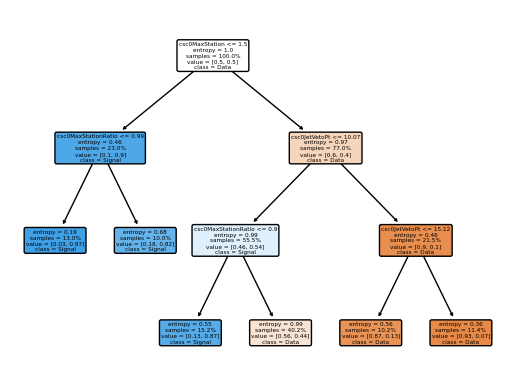

In [188]:
from sklearn import tree
idx = idxs[0]
tree.plot_tree(
    trees[idx],
    feature_names=[test_cols[ift] for ift in indices[idx]],
    class_names=['Data', 'Signal'],
    filled=True,
    proportion=True,
    rounded=True,
    precision=2,
    fontsize=None
)

In [66]:
# from sklearn.ensemble import RandomForestRegressor

# # **** #

# X = np.array([r3_dict[c] for c in test_cols], dtype=float).T
# y = r3_dict['tag_dR']

# # **** #

# rfc = RandomForestRegressor(n_estimators=500, min_samples_leaf=10, max_depth=5, oob_score=True)#, max_features=0.99
# rfc.fit(X, y)

# scores = rfc.feature_importances_
# idxs = np.argsort(scores)[::-1]

# print(f'OOB Score = {rfc.oob_score_}')
# print('')

# for i in idxs:
#     print(test_cols[i], scores[i])

OOB Score = 0.7992021862565695

tag_dEta 0.9566506459194973
csc1MaxStationRatio 0.010308333756661464
csc1MaxChamberRatio 0.008256246723599156
csc1Y 0.0023071831535605835
csc0Y 0.002050922649271547
csc0R 0.0020066601209682558
csc1Z 0.0016350677248903808
csc1R 0.0013446199738682658
csc1X 0.0012873402693496148
csc0MaxStationRatio 0.001261280481487883
csc0X 0.001050109937581263
csc1Phi 0.001037678236962598
csc1Size 0.001006271241553668
csc0NRechitChamberMinus22 0.0009140572240967766
csc0JetVetoE 0.0008912980443524363
csc0Phi 0.0008912512101386975
csc0Eta 0.0007890339170739755
csc0JetVetoPt 0.0007802944444709269
csc1NRechitChamberPlus21 0.0005584788424167194
met 0.0004613870664656702
csc1Eta 0.00041320397602190165
csc0Size 0.000372586175266826
csc0MaxChamberRatio 0.0003398612472959725
csc1NRechitChamberPlus41 0.00029863940500800783
csc0NRechitChamberPlus12 0.00027007379667195525
csc0NRechitChamberPlus22 0.00023350569189861068
NOISE 0.00022017708298746242
csc1AvgStation10 0.00021996549296598

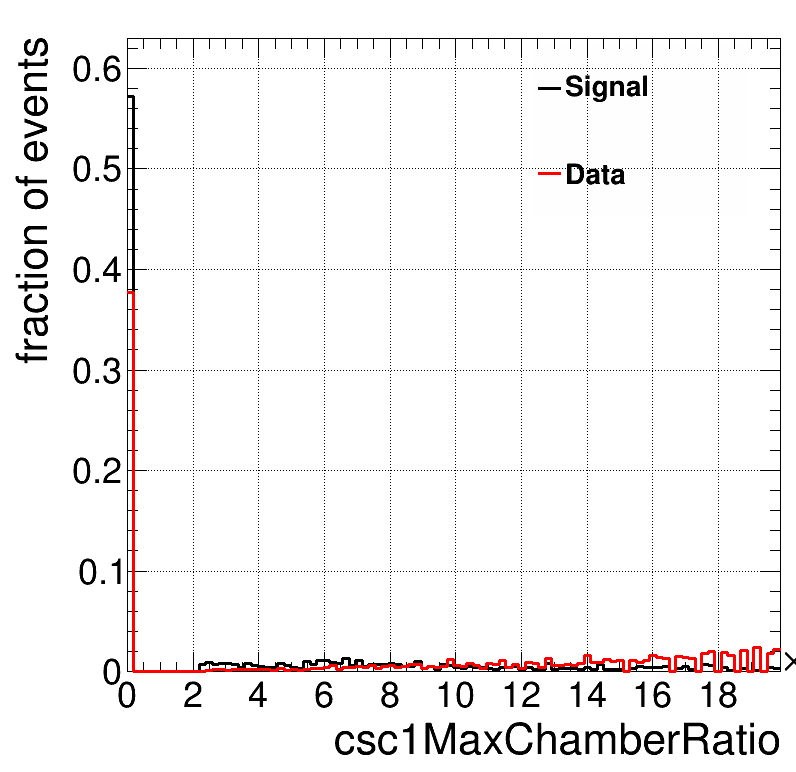

In [183]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.67, 0.72, 0.94, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

# **** #

xv = 'csc0Met_dPhi'
txy_label = f';csc0Met_dPhi;fraction of events'
form =(txy_label,20,0,np.pi)

xv = 'csc0TimeWeighted'
txy_label = f';csc0TimeWeighted;fraction of events'
form =(txy_label,25,-10,15)

# xv = 'csc0Z'
# txy_label = f';Trigger CSC Z Position [cm];fraction of events'
# form =(txy_label,50,500,1100)

# xv = 'csc0Phi'
# txy_label = f';csc0Phi;fraction of events'
# form =(txy_label,10,-np.pi,np.pi)

# xv = 'csc1Phi'
# txy_label = f';csc1Phi;fraction of events'
# form =(txy_label,10,-np.pi,np.pi)

# xv = 'csc0MaxChamber'
# txy_label = f';csc0MaxChamber;fraction of events'
# form =(txy_label,32,0,10000)

# xv = 'csc0MaxStationRatio'
# txy_label = f';csc0MaxStationRatio;fraction of events'
# form =(txy_label,10,0,1)

# xv = 'csc1MaxStationRatio'
# txy_label = f';csc1MaxStationRatio;fraction of events'
# form =(txy_label,10,0,1)

# xv = 'csc1NStation10'
# txy_label = f';csc1NStation10;fraction of events'
# form =(txy_label,20,0,10)

# xv = 'csc1R'
# txy_label = f';2nd csc R;fraction of events'
# form =(txy_label,50,100,600)

# # xv = 'csc1TimeSpreadWeightedAll'
# # txy_label = f';csc1TimeSpreadWeightedAll;fraction of events'
# # form =(txy_label,50,0,20)

# # xv = 'csc0JetVetoLooseId'
# # txy_label = f';csc0JetVetoLooseID;fraction of events'
# # form =(txy_label,50,0,20)

# xv = 'csc0MaxChamberRatio'
# txy_label = f';csc0MaxChamberRatio;fraction of events'
# form =(txy_label,100,0,1)

xv = 'csc1MaxChamberRatio'
txy_label = f';csc1MaxChamberRatio;fraction of events'
form =(txy_label,100,0,19879599.5)

# xv = 'tag_dEta'
# txy_label = f';#Delta#eta;fraction of events'
# form =(txy_label,100,0,5)

# xv = 'tag_dR'
# txy_label = f';#DeltaR;fraction of events'
# form =(txy_label,100,0,5)

# xv = 'tag_dT'
# txy_label = f';tag_dT;fraction of events'
# form =(txy_label,50,0,20)
# form =(txy_label,80,-20,20)


# **** #

h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,).GetValue()
h2 = rdfs['r3'].Histo1D(('Data',*form),xv,).GetValue()
hhs = [h1,h2]

# h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,).GetValue()
# h2 = rdfs['r3'].Filter(f'!({bump_cut})').Histo1D(('Data w/o bump',*form),xv,).GetValue()
# h3 = rdfs['r3'].Filter(bump_cut).Histo1D(('Bump',*form),xv,).GetValue()
# hhs = [h1,h2,h3]


# hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    if hmax < 1 and nev:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')

# l = TLine(1.0,0,1.0,hmax*1.1)
# l.SetLineColor(rt.kMagenta)
# l.SetLineWidth(3)
# l.Draw()

legend.Draw()
canvas.Draw()


684.0
206.0


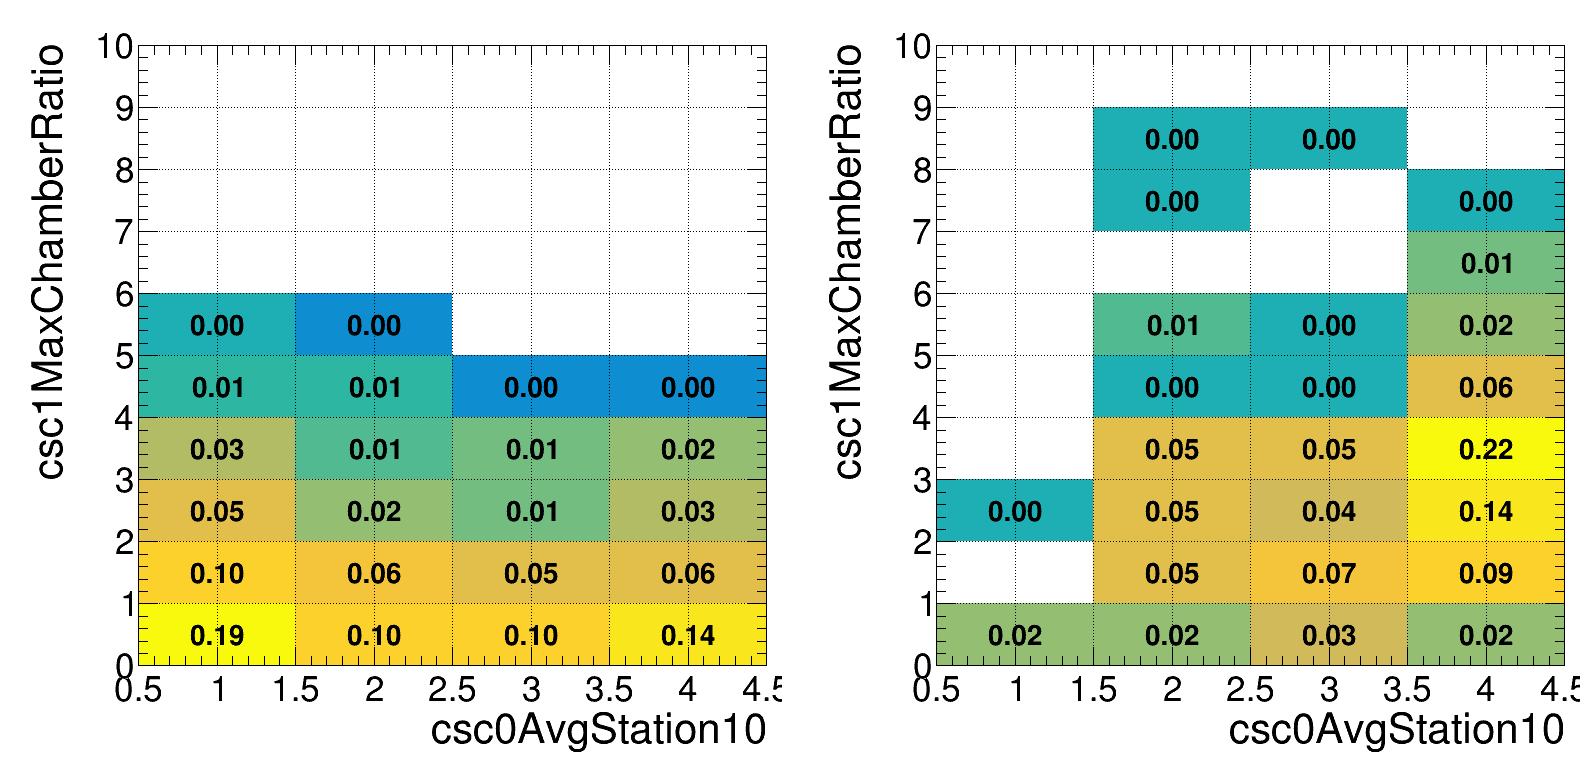

In [175]:
# **** #
 
# nb = 20
# xv, yv = 'csc1Time', 'csc0TimeSpread'
# txy_label = f';csc1Time;csc0TimeSpread;fraction of events'
# bins = (nb, -10, 10, nb, 0, 30)
# logxyz = (False, False, False)

# nb = 20
# xv, yv = 'csc0TimeWeighted', 'csc0TimeSpread'
# txy_label = f';csc0TimeWeighted;csc0TimeSpread;fraction of events'
# bins = (nb, -10, 10, nb, 0, 30)
# logxyz = (False, False, False)

# nb = 20
# xv, yv = 'csc0Phi', 'csc1Phi'
# txy_label = f';1st csc phi;2nd csc phi;fraction of events'
# bins = (nb, 0, np.pi, nb, 0, np.pi)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc0Phi', 'tag_dEta'
# txy_label = f';1st csc phi;#Delta#eta;fraction of events'
# bins = (nb, 0, np.pi, nb, 0, 5)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc1Phi', 'tag_dEta'
# txy_label = f';2nd csc phi;#Delta#eta;fraction of events'
# bins = (nb, 0, np.pi, nb, 0, 5)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc0Phi', 'csc0R'
# txy_label = f';1st csc phi;1st csc R;fraction of events'
# bins = (nb, 0, np.pi, nb, 100, 700)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc1Phi', 'csc1R'
# txy_label = f';2nd csc phi;2nd csc R;fraction of events'
# bins = (nb, 0, np.pi, nb, 100, 700)
# logxyz = (False, False, True)

# nb = 50
# xv, yv = 'csc1R', 'tag_dEta'
# txy_label = f';2nd csc R;#Delta#eta;fraction of events'
# bins = (nb, 100, 700, nb, 0, 1.5)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc0R', 'csc1R'
# txy_label = f';1st csc R;2nd csc R;fraction of events'
# bins = (nb, 100, 700, nb, 100, 700)
# logxyz = (False, False, True)


# nb = 20
# xv, yv = 'csc0MaxStationRatio', 'csc1R'
# txy_label = f';csc0MaxStationRatio;csc1R;fraction of events'
# bins = (10, 0, 1, 10, 100, 700)
# logxyz = (False, False, False)


# nb = 20
# xv, yv = 'csc0Z', 'csc0R'
# txy_label = f';csc0Z;csc0R;fraction of events'
# bins = (nb, 400, 1100, nb, 100, 700)
# logxyz = (False, False, False)

nb = 25
xv, yv = 'csc0Z', 'csc1NStation10'
txy_label = f';csc0Z;csc1NStation10;fraction of events'
bins = (nb, 550, 1100, 4, 0.5, 4.5)
logxyz = (False, False, True)



nb = 25
xv, yv = 'csc0Z', 'csc1MaxChamberRatio'
txy_label = f';csc0Z;csc1MaxChamberRatio;fraction of events'
bins = (nb, 550, 1100, 10, 0, 1)
logxyz = (False, False, True)




# nb = 20
# xv, yv = 'csc1Z', 'csc1R'
# txy_label = f';csc1Z;csc1R;fraction of events'
# bins = (nb, 400, 1100, nb, 100, 700)
# logxyz = (False, False, False)

# nb = 20
# xv, yv = 'csc0MaxStationRatio', 'csc1MaxStationRatio'
# txy_label = f';csc0MaxStationRatio;csc1MaxStationRatio;fraction of events'
# bins = (nb, 0, 1, nb, 0, 1)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'tag_dEta', 'csc1MaxStationRatio'
# txy_label = f';tag_dEta;csc1MaxStationRatio;fraction of events'
# bins = (nb, 0, 5, nb, 0, 1)
# bins = (nb, 0, 1.5, nb, 0, 1)
# logxyz = (False, False, True)


# nb = 10
# xv, yv = 'csc0Time', 'csc1MaxChamberRatio'
# txy_label = f';csc0Time;csc1MaxChamberRatio;fraction of events'
# bins = (nb, -5, 15, nb, 0, 1)
# logxyz = (False, False, True)


# nb = 20
# xv, yv = 'csc0Eta', 'tag_dEta'
# txy_label = f';csc0Eta;tag_dEta;fraction of events'
# bins = (nb, 0, 5, nb, 0, 1)
# bins = (nb, 0, 1.5, nb, 0, 1.5)
# logxyz = (False, False, True)


# nb = 20
# xv, yv = 'tag_dR', 'tag_dEta'
# txy_label = f';tag_dR;tag_dEta;fraction of events'
# bins = (nb, 0, 5, nb, 0, 1)
# bins = (nb, 0, 1.5, nb, 0, 1.5)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'tag_dEta', 'tag_size'
# txy_label = f';tag_dEta;tag_size;fraction of events'
# bins = (nb, 0, 1.5, nb, 50, 100)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'tag_dEta', 'tag_dT'
# txy_label = f';tag_dEta;tag_dT;fraction of events'
# bins = (nb, 0, 1.5, nb, 0, 4)
# logxyz = (False, False, False)


# nb = 10
# xv, yv = 'csc1NStation10', 'csc1MaxStationRatio'
# txy_label = f';csc1NStation10;csc1MaxStationRatio;fraction of events'
# bins = (6, -0.5, 5.5, nb, 0, 1)
# logxyz = (False, False, False)

# nb = 10
# xv, yv = 'csc1AvgStation10', 'csc1MaxStationRatio'
# txy_label = f';csc1AvgStation10;csc1MaxStationRatio;fraction of events'
# bins = (6, -0.5, 5.5, nb, 0, 1)
# logxyz = (False, False, True)


# nb = 10
# xv, yv = 'csc1AvgStation10', 'csc1MaxStation'
# txy_label = f';csc1AvgStation10;csc1MaxStation;fraction of events'
# bins = (6, -0.5, 5.5, 6, -0.5, 5.5)
# logxyz = (False, False, False)

# nb = 10
# xv, yv = 'csc1NStation10', 'csc1AvgStation10'
# txy_label = f';csc1NStation10;csc1AvgStation10;fraction of events'
# bins = (6, -0.5, 5.5, 6, -0.5, 5.5)
# logxyz = (False, False, False)


# nb = 10
# xv, yv = 'csc0AvgStation10', 'csc1NStation10'
# txy_label = f';csc0AvgStation10;csc1NStation10;fraction of events'
# bins = (8, 0.5, 4.5, 4, 0.5, 4.5)
# logxyz = (False, False, False)

nb = 25
xv, yv = 'csc0AvgStation10', 'csc1MaxChamberRatio'
txy_label = f';csc0AvgStation10;csc1MaxChamberRatio;fraction of events'
bins = (4, 0.5, 4.5, 10, 0, 10)
logxyz = (False, False, True)

# **** #


# h1 = rdfs['mc'].Filter('(csc0AvgStation10 < 2) || (csc1NStation10 > 1.5)').Histo2D(('Signal',txy_label,*bins),xv,yv).GetValue()
# h2 = rdfs['r3'].Filter('(csc0AvgStation10 < 2) || (csc1NStation10 > 1.5)').Histo2D(('Data',txy_label,*bins),xv,yv).GetValue()
# hhs = [h1,h2]

h1 = rdfs['mc'].Filter('tag_dPhi > 1').Histo2D(('Signal',txy_label,*bins),xv,yv).GetValue()
h2 = rdfs['r3'].Filter('tag_dPhi > 1').Histo2D(('Data',txy_label,*bins),xv,yv).GetValue()
hhs = [h1,h2]

# h1 = rdfs['mc'].Histo2D(('Signal',txy_label,*bins),xv,yv).GetValue()
# h2 = rdfs['r3'].Filter(f'!({bump_cut})').Histo2D(('Data w/o Bump',txy_label,*bins),xv,yv).GetValue()
# h3 = rdfs['r3'].Filter(bump_cut).Histo2D(('Bump',txy_label,*bins),xv,yv).GetValue()
# hhs = [h1,h2,h3]

# **** #

canvas = TCanvas('','',len(hhs)*800,800)
canvas.Divide(len(hhs),1)


# **** #
rt.gStyle.SetPaintTextFormat('4.2f')

hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
for ih, hh in enumerate(hhs):
    canvas.cd(ih + 1).SetGrid()
    if logxyz[0]:
        canvas.cd(ih + 1).SetLogx()
    if logxyz[1]:
        canvas.cd(ih + 1).SetLogy()
    if logxyz[2]:
        canvas.cd(ih + 1).SetLogz()
    
    print(hh.Integral())
    if hmax <= 1:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    # if ih:
    #     hh.Divide(h1)
    hh.Draw('col text')
    hh.SetMarkerSize(2)
    # hh.Draw('col')



# legend.Draw()
canvas.Draw()
